### Phase 1 Small Grid Test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# --- 1. Data Loading ---
def load_results(filepath):
    """
    Reads the jsonl results file and flattens the dictionary structure
    for easier pandas manipulation.
    """
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            try:
                # Load line as dict
                entry = json.loads(line)
                
                # Flatten specific nested metrics if necessary
                # Example: If 'metrics' is a nested dict, unpack it here
                # For now, assuming flat structure based on your description
                data.append(entry)
            except json.JSONDecodeError:
                print(f"Skipping invalid line: {line[:50]}...")
                continue
    
    return pd.DataFrame(data)

# Use '../' to go up one level from 'notebooks/' to the project root
df = load_results('../phase1_18676818/phase1_results.jsonl')

# Preview to ensure columns match expectations
print(f"Loaded {len(df)} runs.")
print(df.columns.tolist())

Loaded 600 runs.
['prey_birth', 'prey_death', 'predator_birth', 'predator_death', 'grid_size', 'with_evolution', 'seed', 'prey_mean', 'prey_std', 'pred_mean', 'pred_std', 'prey_survived', 'pred_survived', 'prey_n_clusters', 'pred_n_clusters', 'prey_cluster_sizes', 'pred_cluster_sizes', 'prey_largest_fraction', 'pred_largest_fraction', 'pcf_distances', 'pcf_prey_prey', 'pcf_pred_pred', 'pcf_prey_pred', 'segregation_index', 'prey_clustering_index', 'pred_clustering_index']


In [2]:
df.head()

,prey_birth,prey_death,predator_birth,predator_death,grid_size,with_evolution,seed,prey_mean,prey_std,pred_mean,...,pred_cluster_sizes,prey_largest_fraction,pred_largest_fraction,pcf_distances,pcf_prey_prey,pcf_pred_pred,pcf_prey_pred,segregation_index,prey_clustering_index,pred_clustering_index
0,0.2,0.0,0.8,0.05,1000,False,1837646025,33130.908,3395.526250,38323.236,...,"[677, 468, 404, 352, 338, 282, 256, 209, 191, ...",0.025797,0.015026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.2,0.0,0.8,0.05,1000,False,3181451485,32867.412,3174.731052,40033.584,...,"[965, 394, 315, 214, 210, 197, 186, 182, 163, ...",0.036429,0.021114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.2,0.0,0.8,0.05,1000,False,68848981,35417.372,8082.950660,39659.310,...,"[1031, 742, 329, 321, 315, 272, 241, 232, 225,...",0.049771,0.021459,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[0.0, 13.265865540070097, 12.461463681025492, ...","[0.0, 6.122993810634897, 5.762674931616274, 4....","[0.0, 1.3868231618204507, 2.104072025342719, 1...",1.163632,8.575776,3.96189
3,0.2,0.0,0.8,0.05,1000,False,3428376121,33242.668,1790.796956,37196.530,...,"[673, 522, 383, 362, 318, 212, 176, 151, 145, ...",0.035435,0.015646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.2,0.0,0.8,0.05,1000,False,1078973253,35280.352,5226.096169,38910.054,...,"[758, 394, 307, 275, 259, 218, 159, 158, 136, ...",0.036197,0.017014,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   prey_birth             600 non-null    float64
 1   prey_death             600 non-null    float64
 2   predator_birth         600 non-null    float64
 3   predator_death         600 non-null    float64
 4   grid_size              600 non-null    int64  
 5   with_evolution         600 non-null    bool   
 6   seed                   600 non-null    int64  
 7   prey_mean              600 non-null    float64
 8   prey_std               600 non-null    float64
 9   pred_mean              600 non-null    float64
 10  pred_std               600 non-null    float64
 11  prey_survived          600 non-null    bool   
 12  pred_survived          600 non-null    bool   
 13  prey_n_clusters        600 non-null    int64  
 14  pred_n_clusters        600 non-null    int64  
 15  prey_c

In [5]:
df.describe()

,prey_birth,prey_death,predator_birth,predator_death,grid_size,seed,prey_mean,prey_std,pred_mean,pred_std,prey_n_clusters,pred_n_clusters,prey_largest_fraction,pred_largest_fraction,segregation_index,prey_clustering_index,pred_clustering_index
count,600.0,600.000000,600.0,600.00,600.0,6.000000e+02,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,300.000000,300.000000,59.000000,59.000000,59.000000
mean,0.2,0.100000,0.8,0.05,1000.0,2.118074e+09,72572.053093,12186.287812,24798.914520,2122.832611,3717.296667,6916.173333,0.031066,0.004529,0.579280,3.531958,3.754148
std,0.0,0.060748,0.0,0.00,0.0,1.247894e+09,87537.277953,19145.730052,27544.067303,2713.121239,4167.491440,7499.631781,0.042003,0.004186,0.323406,2.499629,2.570441
min,0.2,0.000000,0.8,0.05,1000.0,4.036836e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005744,0.000983,0.154824,0.768496,2.237111
25%,0.2,0.050000,0.8,0.05,1000.0,1.077761e+09,1.028000,3.131976,0.000000,0.000000,0.000000,0.000000,0.009753,0.001784,0.335681,1.627148,2.390519
50%,0.2,0.100000,0.8,0.05,1000.0,2.087804e+09,47431.782000,2977.390739,2446.863000,626.079133,1603.500000,1524.500000,0.013228,0.003111,0.507880,2.761827,2.776449
75%,0.2,0.150000,0.8,0.05,1000.0,3.217958e+09,103826.188000,14213.340401,55652.221500,3581.118846,7020.750000,14905.000000,0.030673,0.005423,0.816200,4.965891,3.455099
max,0.2,0.200000,0.8,0.05,1000.0,4.284761e+09,325297.050000,62391.736244,65345.468000,11739.602184,11998.000000,18122.000000,0.327169,0.024913,1.272909,8.910552,11.755135


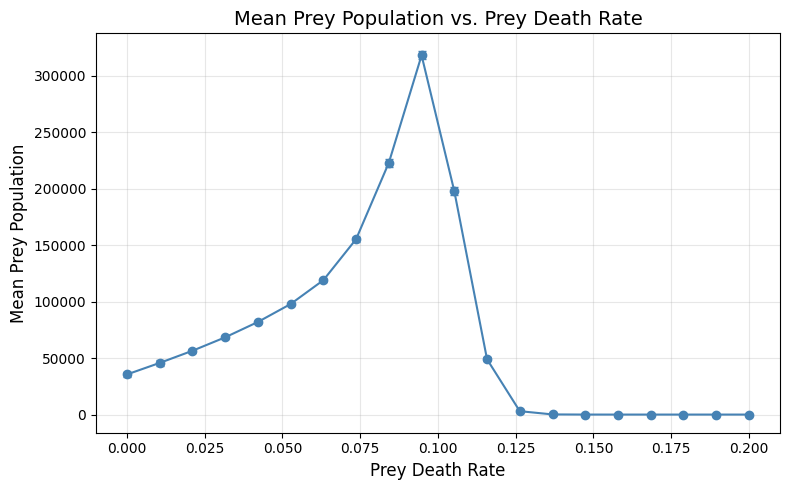

In [6]:
# Group by prey_death, compute mean and std across replicates
grouped = df.groupby('prey_death')['prey_mean'].agg(['mean', 'std']).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(grouped['prey_death'], grouped['mean'], yerr=grouped['std'], 
            fmt='o-', capsize=3, color='steelblue', markersize=6)

ax.set_xlabel('Prey Death Rate', fontsize=12)
ax.set_ylabel('Mean Prey Population', fontsize=12)
ax.set_title('Mean Prey Population vs. Prey Death Rate', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prey_pop_vs_death_rate.png', dpi=150)
plt.show()

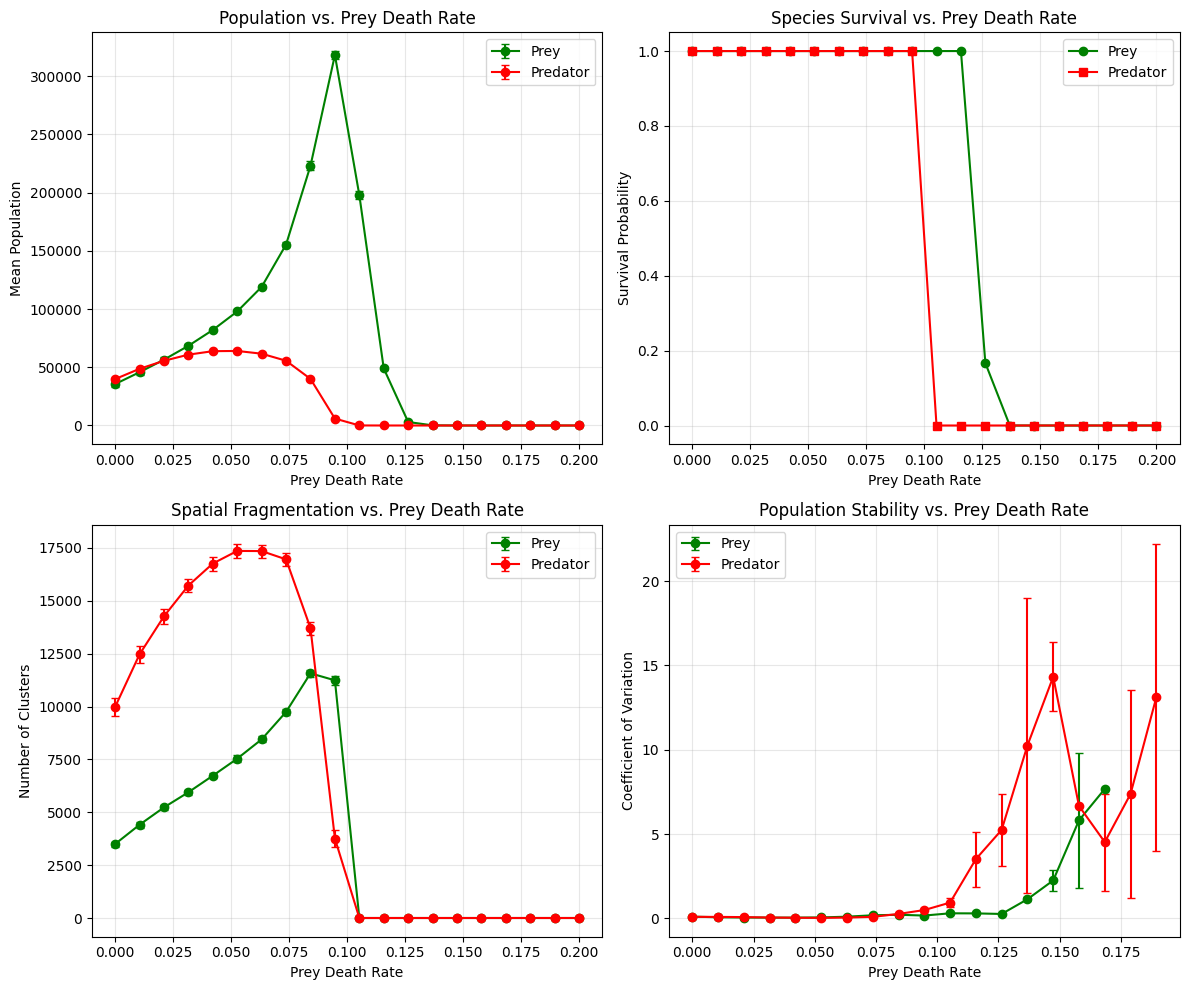

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Prey AND Predator population vs death rate
ax = axes[0, 0]
for pop, label, color in [('prey_mean', 'Prey', 'green'), ('pred_mean', 'Predator', 'red')]:
    agg = df.groupby('prey_death')[pop].agg(['mean', 'std']).reset_index()
    ax.errorbar(agg['prey_death'], agg['mean'], yerr=agg['std'], 
                fmt='o-', capsize=3, label=label, color=color)
ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Mean Population')
ax.set_title('Population vs. Prey Death Rate')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Survival probability
ax = axes[0, 1]
surv = df.groupby('prey_death').agg({
    'prey_survived': 'mean',
    'pred_survived': 'mean'
}).reset_index()
ax.plot(surv['prey_death'], surv['prey_survived'], 'o-', color='green', label='Prey')
ax.plot(surv['prey_death'], surv['pred_survived'], 's-', color='red', label='Predator')
ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Survival Probability')
ax.set_title('Species Survival vs. Prey Death Rate')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Number of clusters (spatial fragmentation)
ax = axes[1, 0]
for col, label, color in [('prey_n_clusters', 'Prey', 'green'), ('pred_n_clusters', 'Predator', 'red')]:
    agg = df.groupby('prey_death')[col].agg(['mean', 'std']).reset_index()
    ax.errorbar(agg['prey_death'], agg['mean'], yerr=agg['std'], 
                fmt='o-', capsize=3, label=label, color=color)
ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Number of Clusters')
ax.set_title('Spatial Fragmentation vs. Prey Death Rate')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Coefficient of variation (population stability)
ax = axes[1, 1]
df['prey_cv'] = df['prey_std'] / df['prey_mean'].replace(0, np.nan)
df['pred_cv'] = df['pred_std'] / df['pred_mean'].replace(0, np.nan)
for col, label, color in [('prey_cv', 'Prey', 'green'), ('pred_cv', 'Predator', 'red')]:
    agg = df.groupby('prey_death')[col].agg(['mean', 'std']).reset_index()
    ax.errorbar(agg['prey_death'], agg['mean'], yerr=agg['std'], 
                fmt='o-', capsize=3, label=label, color=color)
ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Coefficient of Variation')
ax.set_title('Population Stability vs. Prey Death Rate')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('phase1_summary.png', dpi=150)
plt.show()

Prey: Power-law exponent α = 2.09
Predator: Power-law exponent α = 3.02


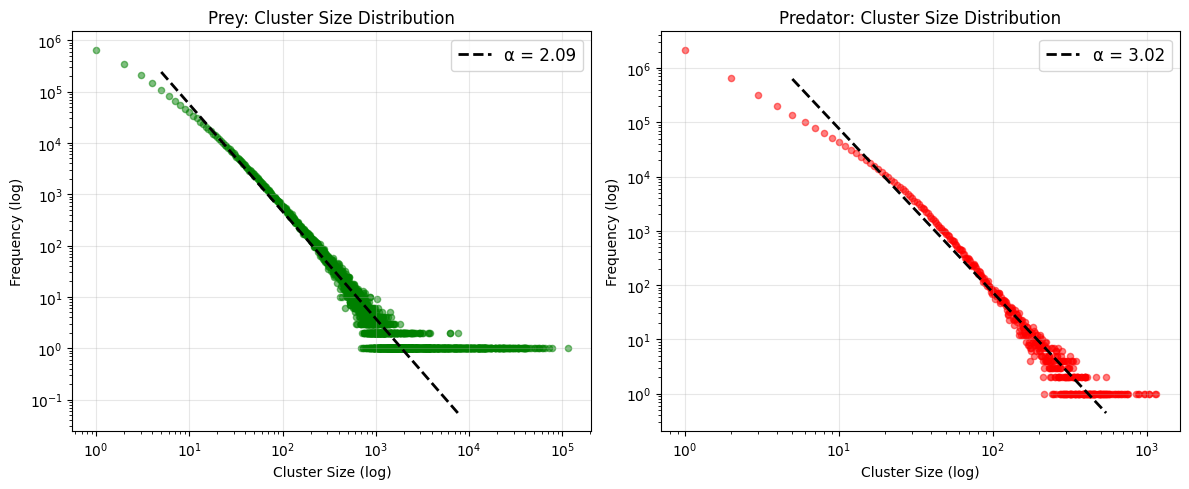

In [11]:
import ast

# Parse cluster sizes
def parse_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x) or x == '[]':
        return []
    try:
        return ast.literal_eval(x)
    except:
        return []

df['prey_clusters_parsed'] = df['prey_cluster_sizes'].apply(parse_list)
df['pred_clusters_parsed'] = df['pred_cluster_sizes'].apply(parse_list)

# ============================================================================
# Power-Law Cluster Size Distribution
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (col, label, color) in zip(axes, [('prey_clusters_parsed', 'Prey', 'green'), 
                                           ('pred_clusters_parsed', 'Predator', 'red')]):
    # Aggregate all cluster sizes
    all_sizes = np.array([s for sizes in df[col] for s in sizes if s > 0])
    
    if len(all_sizes) > 0:
        # Log-log histogram
        sizes, counts = np.unique(all_sizes, return_counts=True)
        ax.scatter(sizes, counts, alpha=0.5, color=color, s=20)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Cluster Size (log)')
        ax.set_ylabel('Frequency (log)')
        ax.set_title(f'{label}: Cluster Size Distribution')
        ax.grid(True, alpha=0.3)
        
        # Power-law fit via linear regression in log-log space
        # P(s) ∝ s^(-α)  =>  log P(s) = -α log(s) + const
        mask = (sizes >= 5) & (counts >= 2)
        if mask.sum() > 5:
            log_s = np.log10(sizes[mask])
            log_c = np.log10(counts[mask])
            slope, intercept = np.polyfit(log_s, log_c, 1)
            
            fit_x = np.logspace(np.log10(sizes[mask].min()), np.log10(sizes[mask].max()), 50)
            fit_y = 10**intercept * fit_x**slope
            ax.plot(fit_x, fit_y, 'k--', lw=2, label=f'α = {-slope:.2f}')
            ax.legend(fontsize=12)
            
            print(f"{label}: Power-law exponent α = {-slope:.2f}")

plt.tight_layout()
plt.savefig('cluster_powerlaw.png', dpi=150)
plt.show()